# Week 10 Problem Set

## Homeworks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

**HW0.** Do the following before starting the homework questions.

**Task 1.** Paste the following functions from your cohort sessions:
- `get_features_target()`
- `normalize_z()`
- `normalize_minmax()`
- `replace_target()`
- `split_data()`
- `prepare_feature()`
- `prepare_target()`
- `calc_logreg()`
- `compute_cost_logreg()`
- `gradient_descent_logreg()`
- `predict_norm()`
- `predict_logreg()`
- `confusion_matrix()`

In [2]:
import itertools
def normalize_z(dfin: pd.DataFrame, columns_means: pd.Series | None = None, columns_stds: pd.Series | None = None):
    if columns_means is None:
        columns_means = dfin.mean(axis=0)
    if columns_stds is None:
        # columns_stds is given as opt arg because if dfin only contains 1 sample (1 row), then dfin.std(axis=0) will be 0 and dfout will be error
        columns_stds = dfin.std(axis=0)
    dfout = (dfin - np.array(columns_means)) / np.array(columns_stds)
    return dfout, columns_means, columns_stds


def get_features_targets(df, feature_names, target_names):
    return df[feature_names], df[target_names]


def prepare_feature(df_feature: pd.DataFrame | np.ndarray):
    res = prepare_target(df_feature)
    return np.insert(res, 0, 1, axis=1)


def prepare_target(df_target: pd.DataFrame | np.ndarray | pd.Series):
    try:
        # df_target.shape returns a tuple #row,#col, i'm expecting 1 here at Week 9
        cols = df_target.shape[1]
    except IndexError:
        cols = 1
    # check if df_target is a dataframe?
    if isinstance(df_target, pd.DataFrame):
        # if yes, convert to numpy using the to_numpy() func from Pandas
        np_target = df_target.to_numpy()
    elif isinstance(df_target, pd.Series):
        np_target = df_target.to_numpy()
    elif isinstance(df_target, np.ndarray):
        # by definition, if arg is not a DF, it will be a numpy array
        np_target = df_target
    return np_target.reshape(-1, cols)


def split_data(df_feature: pd.DataFrame, df_target, random_state=None, test_size=0.3):
    np.random.seed(random_state)

    # generate randomized mask (i.e. list[True|False])
    # test_mask = np.concatenate([
    #     np.ones(int(len(df_feature) * test_size), dtype=bool),
    #     np.zeros(len(df_feature) - int(len(df_feature) * test_size), dtype=bool)
    # ])
    # np.random.shuffle(test_mask)

    test_indexes = np.random.choice(df_feature.index, int(
        len(df_feature) * test_size), replace=False)

    feature_indexes = [
        index for index in df_feature.index if index not in test_indexes]

    # print(test_indexes)

    df_feature_train = df_feature.loc[feature_indexes]
    df_feature_test = df_feature.loc[test_indexes]
    df_target_train = df_target.loc[feature_indexes]
    df_target_test = df_target.loc[test_indexes]

    # df_feature_train = df_feature.loc[~test_mask]
    # df_feature_test  = df_feature.loc[test_mask]
    # df_target_train  = df_target.loc[~test_mask]
    # df_target_test   = df_target.loc[test_mask]

    return df_feature_train, df_feature_test, df_target_train, df_target_test


def normalize_minmax(dfin: pd.DataFrame | np.ndarray, columns_mins=None, columns_maxs=None):
    if isinstance(dfin, np.ndarray):
        if len(dfin.shape) != 2 and columns_mins is not None:
            df = pd.DataFrame(dfin.reshape(-1, len(columns_mins)))
        else:
            df = pd.DataFrame(dfin)
    else:
        df = dfin

    df = df.copy()

    if columns_mins is None:
        columns_mins = df.min(axis=0)
    if columns_maxs is None:
        columns_maxs = df.max(axis=0)

    def normalize(x, i): return (
        x - columns_mins[i]) / (columns_maxs[i] - columns_mins[i])

    for column_i in df.columns:
        df.loc[:, column_i] = df.loc[:, column_i].apply(
            lambda x: normalize(x, column_i))

    if isinstance(dfin, np.ndarray):
        df = df.to_numpy()
        if len(dfin.shape) != 2:
            df = df[0]

    return df, columns_mins, columns_maxs


def replace_target(input_df: pd.DataFrame, target_name, map_vals):
    return input_df.loc[:target_name].replace(map_vals)


def predict_y(X, beta) -> np.ndarray:
    return 1 / (1 + np.exp(-X @ beta))

def calc_logreg(X, beta):
    return predict_y(X, beta)


def compute_total_cost(beta, X, y):
    np.seterr(divide='ignore')
    n = X.shape[0]

    sum_of_errors = np.where(y == 1, np.log(
        predict_y(X, beta)), (1 - y) * np.log(1 - predict_y(X, beta))).sum()

    np.seterr(divide='warn')
    return -1 / n * sum_of_errors


def compute_cost_logreg(beta, X, y):
    return compute_total_cost(beta, X, y)


def gradient_descent_logreg(X, y, beta, learning_rate, num_iters):
    costs = []
    for _ in range(num_iters):
        beta = beta - learning_rate / len(X) * (X.T @ (calc_logreg(X, beta) - y))
        costs.append(compute_total_cost(beta, X, y))
    return beta, costs


def predict_norm(X, beta):
    return np.fromiter((1 if i > 0.5 else 0 for i in calc_logreg(X, beta)), X.dtype).reshape(-1, 1)


def predict_logreg(df_feature, beta, means=None, stds=None):
    feature = prepare_feature(normalize_z(df_feature, means, stds)[0])
    return predict_norm(feature, beta)


def confusion_matrix(ytrue, ypred, labels):
    positive_label, negative_label = labels
    print(labels)
    res = {pair: 0 for pair in itertools.product(labels, labels)}

    print(res)

    for predicted, actual in zip(ytrue, ypred):
        if predicted == 1 and actual == 1:
            res[(positive_label, positive_label)] += 1
        elif predicted == 0 and actual == 1:
            res[(negative_label, positive_label)] += 1
        elif predicted == 1 and actual == 0:
            res[(positive_label, negative_label)] += 1
        elif actual == 0 and predicted == 0:
            res[(negative_label, negative_label)] += 1
    return res

**Task 2.** Load the Iris data set from `iris_data.csv` into a Data Frame. 

    

In [3]:
# read iris_data.csv
df = pd.read_csv("./iris_data.csv")

###
### YOUR CODE HERE
###
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


**Task 3.** Do the following tasks.

- Read the following columns for the features: `'sepal_length', 'sepal_width', 'petal_length', 'petal_width'`.
- Read the column `species` for the target.
- Replace the `species` column with the following mapping:
    - `Iris-setosa`: `0`
    - `Iris-versicolor`: `1`
    - `Iris-virginica`: `2`

In [4]:
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

# extract the features and the target
df_features, df_target = get_features_targets(df, columns, ["species"])

# replace the target using the mapping
df_target = replace_target(
    df_target,
    "species",
    mapping
)

In [5]:
result = np.unique(df_target['species'], return_counts=True)
assert (result[0] == [0, 1, 2]).all()
assert (result[1] == [50, 50, 50]).all()

**HW1.** *One-vs-All target:* Write a function that takes in a target data frame and returns a new dataframe where the size of the column is the same as the number of category. The function makes use of `replace_target()` function to create one-vs-all target values. 

For example, if we have three categories of class, the columns of the returned data frame will be as follows:
- column target: this is the original target column
- column 0: the target with values of 0 will be set to 1 while the rest will be replaced with 0.
- column 1: the target with values of 1 will be set to 1 while the rest will be replaced with 0.
- column 2: the target with values of 2 will be set to 1 while while the rest will be replaced with 0.

In [6]:
def create_onevsall_columns(df_target: pd.DataFrame, col):
    dfout = df_target.copy()
    for index, row in dfout.iterrows():
        dfout.loc[index, 0] = 1 if dfout.loc[index, 'species'] == 0 else 0
        dfout.loc[index, 1] = 1 if dfout.loc[index, 'species'] == 1 else 0
        dfout.loc[index, 2] = 1 if dfout.loc[index, 'species'] == 2 else 0
    return dfout

In [7]:
df_targets = create_onevsall_columns(df_target, 'species')
print(df_targets)
result = np.unique(df_targets['species'], return_counts=True)
assert (result[0] == [0, 1, 2]).all()
assert (result[1] == [50, 50, 50]).all()
result = np.unique(df_targets[0], return_counts=True)
assert (result[0] == [0, 1]).all()
assert (result[1] == [100, 50]).all()
result = np.unique(df_targets[1], return_counts=True)
assert (result[0] == [0, 1]).all()
assert (result[1] == [100, 50]).all()
result = np.unique(df_targets[2], return_counts=True)
assert (result[0] == [0, 1]).all()
assert (result[1] == [100, 50]).all()

     species    0    1    2
0          0  1.0  0.0  0.0
1          0  1.0  0.0  0.0
2          0  1.0  0.0  0.0
3          0  1.0  0.0  0.0
4          0  1.0  0.0  0.0
..       ...  ...  ...  ...
145        2  0.0  0.0  1.0
146        2  0.0  0.0  1.0
147        2  0.0  0.0  1.0
148        2  0.0  0.0  1.0
149        2  0.0  0.0  1.0

[150 rows x 4 columns]


In [8]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**HW2.** *Multiple features and splitting of data set:* Do the following task in the code below:
- Read the following columns for the features: `sepal_length`,`sepal_width`, `petal_length`, `petal_width` normalize it using `normalize_z()`. 
- Read `species` as the target column and use `create_onevsall_columns()` to create the additional target columns to do multi class classification.
- Split the data set with 30% test size and `random_state = 100`.
- Normalize the training feature data set using `normalize_z()` function.
- Convert to numpy array both the target and the features using `prepare_feature()` and `prepare_target()` functions.
- Call `gradient_descent_logreg()` function to get the parameters using the training data set.

In [9]:
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

# split the data using random_state = 100 and 30% test size
df_features_train, df_features_test, df_targets_train, df_targets_test = split_data(
    df_features, df_targets, random_state=100, test_size=0.3
)

# normalize the training feature
df_features_train_z, means, stds = normalize_z(df_features_train)
feature = prepare_feature(df_features_train_z)
target = prepare_target(df_target)

In [10]:
assert df_features_train_z.shape == (105, 4)

assert np.isclose(df_features_train_z.min(), -2.52349).any()
assert np.isclose(df_features_train_z.max(), 2.73284).any()
assert np.isclose(df_features_train_z['sepal_width'].mean(), 0)
assert np.isclose(df_features_train_z['sepal_width'].std(), 1, atol=0.01)

print(df_targets_train)

assert (np.unique(df_targets_train['species']) == [0, 1, 2]).all()
assert (np.unique(df_targets_train[0]) == [0, 1]).all()
assert (np.unique(df_targets_train[1]) == [0, 1]).all()
assert (np.unique(df_targets_train[2]) == [0, 1]).all()


     species    0    1    2
0          0  1.0  0.0  0.0
2          0  1.0  0.0  0.0
3          0  1.0  0.0  0.0
4          0  1.0  0.0  0.0
5          0  1.0  0.0  0.0
..       ...  ...  ...  ...
142        2  0.0  0.0  1.0
143        2  0.0  0.0  1.0
144        2  0.0  0.0  1.0
147        2  0.0  0.0  1.0
148        2  0.0  0.0  1.0

[105 rows x 4 columns]


In [11]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**HW3.** *Build Multi-class Model:* Write a function `build_model_multiclass()` which takes in the following arguments:
- `df_features`: which is a Pandas data framecontaining the features.
- `df_targets`: which is a Pandas data frame containing the target for one vs all classification. 
- `col_target`: the name of the column target in the original data frame which is also the key of the dictionary containing the original target numpy array.
- `iterations`: the number of iterations to perform the gradient descent. By default it is set to 1500.
- `alpha`: the learning rate in the gradient descent algorithm. By default it is set to 0.01.

The function should return a dictionary of dictionary. The output dictionary has the following key and values:
- key: the keys are the categories or the labels in the target.
- values: the values are another dictionary for that particular label. This dictionary has two keys: `beta` and `J_storage`, which gives the parameter value for that particular label and its cost minimization values at every iteration.

Hint:
- you need to call `prepare_feature()` and `prepare_target()` to change the Pandas data frame to Numpy arrays.
- in order to create a data frame instead of a series when accessing a column, use `df[[c]]` (will output data frame) instead of `df[c]` (will output series). 
- You need to use `normalize_minmax()` on your target before passing it on to `gradient_descent_logreg()` because the function logistic regression has the normalized value of 0 to 1 in the y axis.

In [12]:
def build_model_multiclass(df_features, df_targets, col_target, iterations=1500, alpha=0.01):
    output = dict()
    feature = prepare_feature(df_features)
    for flower_class in np.unique(df_targets.loc[:, col_target]):
        target = normalize_minmax(prepare_target(df_targets[[flower_class]]))[0]
        beta_initial = np.zeros((feature.shape[1], 1))
        beta, J_storage = gradient_descent_logreg(feature, target, beta_initial, alpha, iterations)
        output[flower_class] = {
            "beta": beta,
            "J_storage": J_storage
        }
        
    return output
    

In [13]:
output = build_model_multiclass(df_features_train_z, df_targets_train, 'species')

print(output)

assert isinstance(output, dict)
expected = np.array([[ -1.0198841], [ -0.69883077], [  1.0774116], [-1.17170999], [-1.12846826]])
assert np.isclose(output[0]['beta'], expected).all()
expected = np.array([[ -0.63304937], [ 0.11684857], [-1.15346071], [ 0.18746937], [-0.14534827 ]])
assert np.isclose(output[1]['beta'], expected).all()
expected = np.array([[-1.31740148 ], [0.42271871], [0.18526839], [ 0.8831822], [1.17929455]])
assert np.isclose(output[2]['beta'], expected).all()

{0: {'beta': array([[-1.0198841 ],
       [-0.69883077],
       [ 1.0774116 ],
       [-1.17170999],
       [-1.12846826]]), 'J_storage': [0.687399485137097, 0.681729734797857, 0.6761368273919243, 0.6706196683865141, 0.6651771712910158, 0.6598082580552793, 0.6545118594421361, 0.6492869153747892, 0.6441323752597268, 0.639047198285845, 0.6340303537004748, 0.6290808210630292, 0.6241975904769936, 0.6193796628009913, 0.6146260498396647, 0.6099357745151102, 0.6053078710196059, 0.6007413849503769, 0.5962353734271206, 0.5917889051930328, 0.5874010607000413, 0.583070932178965, 0.5787976236952946, 0.574580251191278, 0.5704179425149875, 0.5663098374370245, 0.5622550876555032, 0.5582528567899429, 0.5543023203646762, 0.5504026657823681, 0.5465530922882181, 0.5427528109254076, 0.539001044482325, 0.5352970274320973, 0.5316400058649245, 0.5280292374137057, 0.5244639911734189, 0.5209435476147094, 0.5174671984921096, 0.5140342467473079, 0.5106440064078611, 0.5072958024817278, 0.5039889708479832, 0.50072

In [14]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


class model = 0 [[-1.0198841 ]
 [-0.69883077]
 [ 1.0774116 ]
 [-1.17170999]
 [-1.12846826]]
class model = 1 [[-0.63304937]
 [ 0.11684857]
 [-1.15346071]
 [ 0.18746937]
 [-0.14534827]]
class model = 2 [[-1.31740148]
 [ 0.42271871]
 [ 0.18526839]
 [ 0.8831822 ]
 [ 1.17929455]]


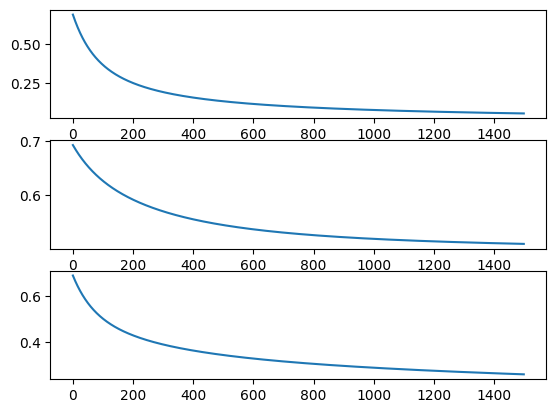

In [15]:
fig, axes = plt.subplots(len(output), 1)
idx = 0
for c in output:
    print(f'class model = {c:}', output[c]['beta'])
    axes[idx].plot(output[c]['J_storage'])
    idx += 1

**HW4.** *Predict Multi-class:* Write a function `predict_multiclass()` that takes in the data frame for the features and the parameters for the multi-class classification and return a Numpy array for the predicted target.

Recall that you need to do the following steps:
- Normalize the features and change to numpy array
- For each of the class, calculate the probability by using `calc_logreg()` function.
- For each record, find the class that gives the maximum probability.
- Returns a Numpy array with the predicted target values

You can use the following function in your code:
- `np.argmax()` to find the column name with the maximum value
- `df.apply(func, axis=1)`: which is to apply some function on a particular axis. Setting axis=1 means that the function is to be applied accross the columns of the data frame instead of the index or the rows. 

In [31]:
def predict_multiclass(df_features, multi_beta: dict, means=None, stds=None):
    feature = prepare_feature(normalize_z(df_features, means, stds)[0])
    print(feature)
    results = np.ndarray((len(multi_beta), len(feature)))
    for i, weights_object in enumerate(multi_beta.values()):
        beta = weights_object["beta"]
        results[i] = calc_logreg(feature, beta).T
    results = results.T
    return np.argmax(results, axis=1).reshape((len(feature), 1))
        

In [32]:
pred = predict_multiclass(df_features_test, output)

assert isinstance(pred, np.ndarray)
assert pred.shape == (45, 1)
assert pred.min() == 0
assert pred.max() == 2
assert np.median(pred) == 1

[[ 1.          0.52247127 -0.52757753  0.94649397  1.03112567]
 [ 1.         -1.31254977  0.74426116 -1.17780671 -1.24107137]
 [ 1.          2.01342586 -0.95152376  1.63689169  1.27030431]
 [ 1.         -0.28035044  2.8639923  -1.23091423 -1.00189273]
 [ 1.          0.40778245 -0.73955064  0.57474135  0.67235772]
 [ 1.          2.01342586 -0.1036313   1.21203155  1.27030431]
 [ 1.         -0.85379451  2.22807295 -1.23091423 -1.36066068]
 [ 1.         -1.19786095 -0.1036313  -1.28402174 -1.24107137]
 [ 1.          0.63716008 -0.1036313   0.89338645  0.67235772]
 [ 1.         -1.31254977 -0.1036313  -1.28402174 -1.12148205]
 [ 1.         -1.08317214  0.95623427 -1.33712926 -1.12148205]
 [ 1.          0.52247127  0.32031493  0.78717142  1.27030431]
 [ 1.         -1.08317214  0.74426116 -1.17780671 -1.00189273]
 [ 1.         -0.85379451  0.74426116 -1.28402174 -1.24107137]
 [ 1.          0.86653771 -0.1036313   0.7340639   1.27030431]
 [ 1.          0.29309364 -0.31560441  0.25609625  0.07

In [18]:
input_1row = np.array([[6.3, 3.4, 5.6, 2.4]])
print(means)
print(stds)
pred_1row = predict_multiclass(input_1row, output, means, stds)
assert pred_1row[0][0] == 2

sepal_length    5.800000
sepal_width     3.056190
petal_length    3.733333
petal_width     1.181905
dtype: float64
sepal_length    0.808964
sepal_width     0.418542
petal_length    1.719887
petal_width     0.733246
dtype: float64


In [19]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


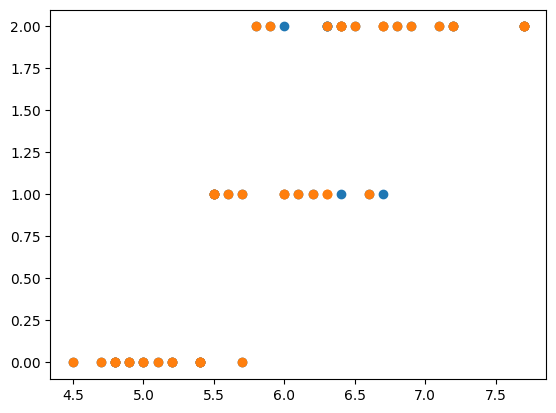

In [20]:
plt.scatter(df_features_test['sepal_length'], df_targets_test['species'])
plt.scatter(df_features_test['sepal_length'], pred)

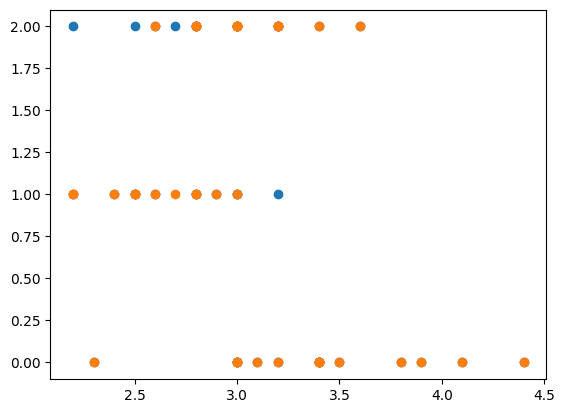

In [21]:
plt.scatter(df_features_test['sepal_width'], df_targets_test['species'])
plt.scatter(df_features_test['sepal_width'], pred)

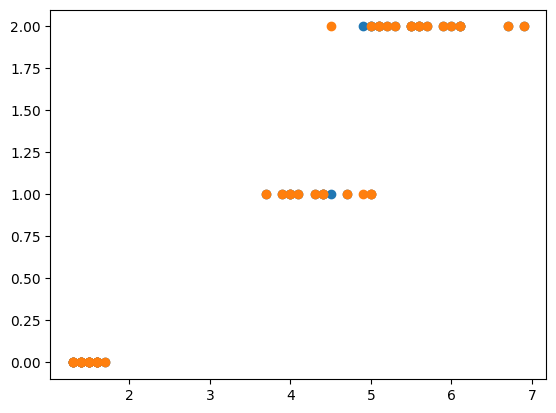

In [22]:
plt.scatter(df_features_test['petal_length'], df_targets_test['species'])
plt.scatter(df_features_test['petal_length'], pred)

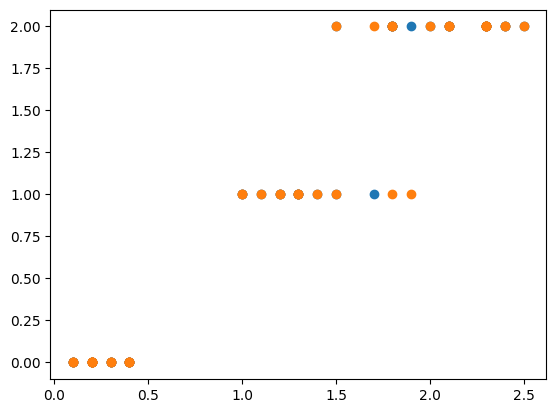

In [23]:
plt.scatter(df_features_test['petal_width'], df_targets_test['species'])
plt.scatter(df_features_test['petal_width'], pred)

**HW5.** *Confusion Matrix:* Write a function to calculate the confusion matrix for multi-class label. If you write the solution in the Cohort session properly, the solution will be the same as in the Cohort session.

Make sure that you can output a dictionary where the keys are all the combinations of all the classes: `(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)`.

In [24]:
import itertools


def confusion_matrix(ytrue, ypred, labels):
    res = {trio: 0 for trio in itertools.product(labels, labels)}

    for predicted, actual in zip(ytrue, ypred):
        res[(predicted[0], actual[0])] += 1
    
    return res

In [25]:
cm = confusion_matrix(df_targets_test.values, pred, [0, 1, 2])
print(cm)
assert cm == {(0, 0): 16, (0, 1): 0, (0, 2): 0, (1, 0): 0, (1, 1): 9, (1, 2): 2, (2, 0): 0, (2, 1): 3, (2, 2): 15} or cm =={(0, 0): 16, (0, 1): 0, (0, 2): 0, (1, 0): 0, (1, 1): 8, (1, 2): 3, (2, 0): 0, (2, 1): 3, (2, 2): 15}

{(0, 0): 16, (0, 1): 0, (0, 2): 0, (1, 0): 0, (1, 1): 9, (1, 2): 2, (2, 0): 0, (2, 1): 3, (2, 2): 15}


In [26]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**HW6.** *Metrics:* Write a function `calc_accuracy()` that takes in a Confusion Matrix array and output a dictionary with the following keys and values:
- `accuracy`: total number of correct predictions / total number of records
- `sensitivity`: total correct positive cases / total positive cases
- `precision`: total  of correct positive cases / total predicted positive cases

For multiple classes, we can also calculate *sensitivity* and *precision* for each of the class. For example, to calculate the sensitivity for class *i*, we use:

$$\text{sensitivity}_i = \frac{M_{ii}}{\sum_j{M_{ij}}}$$

This means that we get the value at row *i* and columnn *i* which is the total correct case for class *i* and the sum over all the columns in row *i* which is the total cases for class *i*. 

Similarly, we can calculate the precision for class *i* using:

$$\text{precision}_i = \frac{M_{ii}}{\sum_j{M_{ji}}}$$

**Notice that the indices are swapped for the denominator**. For precision, we instead of summing over all the columns, we sum over all the rows in column *i* which is the total cases when class *i* is *predicted*.

The output is a dictionary with one of the keys called `accuracy` and the rest of the keys are the label for the different classes, i.e. 0, 1, and 2 in our example here. The value for `accuracy` key is a float. On the other hand, the values for the other label keys is another dictionary that has `sensitivity` and `precision` as the keys.

In [27]:
def calc_accuracy(cm, labels):
    output = { 'accuracy': sum(cm[(l, l)] / sum(cm.values()) for l in labels) }
    for i in labels:
        output[i] = {
            'precision': cm[(i, i)] / sum(cm[(j, i)] for j in labels),
            'sensitivity': cm[(i, i)] / sum(cm[(i, j)] for j in labels)
        }
    ###
    ### YOUR CODE HERE
    ###
    return output

In [28]:
metrics = calc_accuracy(cm, [0,1,2])
print(metrics)
assert np.isclose(metrics['accuracy'], 0.8666667) or np.isclose(metrics['accuracy'], 0.8888888)
assert metrics[0] == {'sensitivity': 1.0, 'precision': 1.0} 
assert np.isclose(metrics[0]['sensitivity'], 1.0)
assert np.isclose(metrics[0]['precision'], 1.0)
assert np.isclose(metrics[1]['sensitivity'], 0.72727272) or np.isclose(metrics[1]['sensitivity'], 0.818181818)
assert np.isclose(metrics[1]['precision'], 0.72727272) or np.isclose(metrics[1]['precision'], 0.75)
assert np.isclose(metrics[2]['sensitivity'], 0.833333)
assert np.isclose(metrics[2]['precision'], 0.833333) or np.isclose(metrics[2]['precision'], 0.88235294)


{'accuracy': 0.8888888888888888, 0: {'precision': 1.0, 'sensitivity': 1.0}, 1: {'precision': 0.75, 'sensitivity': 0.8181818181818182}, 2: {'precision': 0.8823529411764706, 'sensitivity': 0.8333333333333334}}


In [29]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**HW7.** *Optional:* Redo the above tasks using Scikit Learn libraries. You will need to use the following:
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

You can refer to the followign discussion on the different minimization solver for `LogisticRegression()` class.
- [Stack overflow - logistic regression python solvers' defintions](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica':2}

# get the features and the columns
df_features = None

# replace target values with integers using the mapping
df_target = None


###
### YOUR CODE HERE
###


In [ ]:
# split data set using random_state = 100 and 30% test size
df_features_train, df_features_test, df_target_train, df_target_test = None, None, None, None

# change feature to numpy array and append column of 1s
feature = None

# change target to numpy array
target = None

###
### YOUR CODE HERE
###


In [ ]:
# create LogisticRegression object instance
# set solver to 'newton-cg' and multi_class to 'auto'
model = None

# build model
pass

# get predicted value
pred = None

###
### YOUR CODE HERE
###


In [ ]:
# calculate confusion matrix
cm = None

###
### YOUR CODE HERE
###
print(cm)


In [ ]:
expected = np.array([[16,  0,  0], [ 0, 11,  0], [ 0,  1, 17]])
assert (cm == expected).all()

In [ ]:
plt.scatter(df_features_test["sepal_width"], df_target_test)
plt.scatter(df_features_test["sepal_width"], pred)

In [ ]:
plt.scatter(df_features_test["sepal_length"], df_target_test)
plt.scatter(df_features_test["sepal_length"], pred)

In [ ]:
plt.scatter(df_features_test["petal_width"], df_target_test)
plt.scatter(df_features_test["petal_width"], pred)

In [ ]:
plt.scatter(df_features_test["petal_length"], df_target_test)
plt.scatter(df_features_test["petal_length"], pred)